In [1]:
import numpy as np
import scipy
from scipy.cluster import hierarchy as hc
import pandas as pd
from skimage import morphology
from scipy import misc
from matplotlib import pyplot as plt
import math, time
from skimage import measure

In [2]:
%matplotlib inline  

In [3]:
## Set user-defined variables
image_index = 137
roll_width = 20
sdir = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2015_09_16_fast/g21flow'
image = 'bmps_cropped/%05d.bmp' % image_index
pattern_matches = 'pattern_data/%05d_matches.csv' % image_index
sing_points = 'singular_points/%05d.txt' % image_index

In [4]:
## Load the pattern matching data
bmp = misc.imread(sdir + "/" + image)
bmp = bmp.astype(float)
matches = pd.read_csv(sdir + "/" + pattern_matches)
singular_points = pd.read_csv(sdir + "/" + sing_points, sep=' ', names=['x', 'y', 'type'])

In [5]:
def Plot(list_of_things_to_plot):
    plt.rcParams['figure.figsize'] = (20.0, 10.0)
    for i,x in enumerate(list_of_things_to_plot):
        plt.subplot(1,len(list_of_things_to_plot),i+1,aspect='equal'); plt.pcolor(x); plt.colorbar(); plt.gca().invert_yaxis()
    

In [6]:
## Create mask/classification image
mask = np.zeros(bmp.shape) # Location of masks
maskids = {0:'Unassigned'} # Definitions of mask types

In [7]:
## GET PARALLEL ROLL REGIONS
# Dilate the absolute value of the singular_points by 1 roll_width
# Mask out the original image by this dilation
# Remaining regions are the parallel roll regions

singular_points = singular_points.astype(np.int)
sp = np.zeros(bmp.shape)
sp[singular_points['x'], singular_points['y']] = 1

sp_dilated = morphology.binary_dilation(sp, morphology.disk(roll_width))

# Remove small regions not filtered out
sp_dilated = morphology.binary_dilation(sp_dilated, morphology.disk(0.5*roll_width))
sp_dilated = morphology.binary_erosion(sp_dilated, morphology.disk(0.5*roll_width))

# Invert to ge the indicator function for the parallel roll regions
sp_dilated_mask = np.invert(sp_dilated)

# Add these regions to the mask
mask[sp_dilated_mask] = 1
maskids[1] = 'Parallel rolls'


In [8]:
## GET ROLL INSTABILITIES
# Find pinch persistence pinches within parallel roll regions

pinches = matches.loc[(matches['match_type']=='pinch_upper') | (matches['match_type']=='pinch_lower')][['center_x','center_y']]
pinches = pinches.astype(np.int)

p = np.zeros(bmp.shape)
p[pinches['center_y'], pinches['center_x']] = 1

p = np.multiply(sp_dilated_mask, p)
p = morphology.binary_dilation(p, morphology.disk(0.25*roll_width))
p = np.multiply(sp_dilated_mask, p)

# Add these regions to the mask
mask[p] = 2
maskids[2] = 'Roll instabilities'


In [9]:


def add_defect(defect_region, id, name, isstable, attribute):
    mask[defect_region] = id
    maskids[id] = name
    image_defects.append([id, isstable, attribute])
    # Get cropping coordinates from the defect region



# GLOBAL VARIABLES USED
# singular_points


def classify_defect(defect, isstable):

    # Intersect defect with singular points
    defect_points = defect*sp

    # Convert to list of singular_point locations inside of defect region
    defect_list = (defect_points).nonzero()
    defect_list = np.column_stack((defect_list[0], defect_list[1]))
    defect_list = pd.DataFrame(defect_list,columns=['x','y'])
    defect_list = pd.merge(defect_list, singular_points, on=['x', 'y'])

    no_sps = len(defect_list)

    if no_sps == 1:

        # Singleton (-1) = disclination (branch type)
        # Compute upper or lower disclination
        if defect_list['type'][0]==-1:
            if bmp[defect_list['x'][0],defect_list['y'][0]] <= np.median(np.median(bmp)):
                add_defect(defect, 4, 'Disclination (convex), lower', isstable, 'center=(%d,%d)' % (defect_list['x'][0],defect_list['y'][0]))
            else:
                add_defect(defect, 5, 'Disclination (convex), upper' , isstable, 'center=(%d,%d)' % (defect_list['x'][0],defect_list['y'][0]))

        # Singleton (+1) = disclination (lobe type)
        # Compute upper or lower disclination
        if defect_list['type'][0]==1:
            if bmp[defect_list['x'][0],defect_list['y'][0]] <= np.median(np.median(bmp)):
                add_defect(defect, 7, 'Disclination (concave), lower' , isstable, 'center=(%d,%d)' % (defect_list['x'][0],defect_list['y'][0]))
            else:
                add_defect(defect, 8, 'Disclination (concave), upper' , isstable, 'center=(%d,%d)' % (defect_list['x'][0],defect_list['y'][0]))

    if no_sps == 2:

        avg_x = np.average(defect_list['x'])
        avg_y = np.average(defect_list['y'])

        # Pair of (1, -1) = dislocation
        # Compute upper or lower disclination
        if len(defect_list.loc[defect_list['type']==1]) == 1:
            add_defect(defect, 10, 'Dislocation' , isstable, 'center=(%d,%d)' % (avg_x,avg_y))

        # Pair of (1, 1) = spiral or possibly a target
        # Compute the center and width (can be used to estimate the number of arms)
        if len(defect_list.loc[defect_list['type']==1]) == 2:

            # Get distance from center (average) to closest singular point
            # This is the width of the spiral.
            # Color area the size of this circular region as the spiral color.

            other_sps = pd.concat([singular_points, defect_list]).drop_duplicates(keep=False)
            other_sps = other_sps.append({'x':avg_x, 'y':avg_y, 'type':0}, ignore_index=True)

            dm = scipy.spatial.distance.pdist(other_sps.as_matrix(columns=['x','y']))
            dm = scipy.spatial.distance.squareform(dm)

            neighbors = dm[-1,:]
            neighbors = neighbors[neighbors>0]

            spiral = np.zeros(bmp.shape)
            spiral[avg_x, avg_y] = 1
            spiral = morphology.binary_dilation(spiral, morphology.disk(min(neighbors)))

            # Use H1 sublevel (existence of plume) to disambiguate spirals
            # If any plume exists inside the radius of the spiral, turn it into a target

            target = np.multiply(spiral, plumes)

            if sum(sum(target)) > 0:
                add_defect(spiral, 12, 'Target' , isstable, 'center=(%d,%d), radius=%0.2f' % (avg_x,avg_y,min(neighbors)))
            else:
                add_defect(spiral, 14, 'Spiral' , isstable, 'center=(%d,%d), radius=%0.2f' % (avg_x,avg_y,min(neighbors)))


    if no_sps >= 3:
        
        # Do a SVD to see line of best fit and how well the configuration fits into a line.
        # If it does, the it's potentially a grain boundary of length > 1

        data = np.column_stack(((defect_points).nonzero()[0], (defect_points).nonzero()[1]))
        datamean = data.mean(axis=0)
        uu, dd, vv = np.linalg.svd(data - datamean)
        # vv[0] is the direction vector of the line of best fit. Need to get dot products of
        # original points with this vector vv[0] to put them in order along the line
        ordering = np.dot((data - datamean),np.reshape(vv[0],(2,1)))
        # Append the ordering values to the dataframe
        defect_list['order'] = ordering
        defect_list = defect_list.sort(['order'])
        # Check that the ordering along the principal component is alternating with respect to the singular point type
        isAlternating = (sum(abs(defect_list['type'][0:len(defect_list)-1].as_matrix() + defect_list['type'][1:len(defect_list)].as_matrix())) == 0)
        # Check that the points aren't too close to linear
        isLinear = (dd[1] < (1./5.)*roll_width)
        isDispersed = (dd[1] > (3./4.)*roll_width)
        if (isAlternating & ~isLinear & ~isDispersed):
            add_defect(defect, 11, 'Grain boundary' , isstable, 'chain_length=%d' % (int(no_sps-1)/2.))
        elif (len(defect_list.loc[defect_list['type']==1]) == 2):
            # Check to see if it is a target. Presence of two +1 defects that don't have any -1 in between them
            target_points = defect_list.loc[defect_list['type']==1]
            avg_x = np.average(target_points['x'])
            avg_y = np.average(target_points['y'])
            defect_list['distance'] = defect_list.apply(lambda d: np.linalg.norm(np.asarray([d['x'],d['y']])-np.asarray([avg_x,avg_y])), axis=1)
            center_points = defect_list.loc[defect_list['type']==1]
            outside_points = defect_list.loc[defect_list['type']==-1]
            min_center = min(center_points['distance'])
            min_outside = min(outside_points['distance'])
            if (min_outside > 1.25*min_center):
                for i in outside_points.index:
                    disclination = np.zeros(bmp.shape)
                    o_x = int(outside_points.ix[i]['x'])
                    o_y = int(outside_points.ix[i]['y'])
                    disclination[o_x,o_y] = 1
                    disclination = morphology.binary_dilation(disclination, morphology.disk(0.5*roll_width))
                    if bmp[o_x,o_y] <= np.median(np.median(bmp)):
                        add_defect(disclination, 4, 'Disclination (convex), lower', isstable, 'center=(%d,%d)' % (o_x,o_y))
                    else:
                        add_defect(disclination, 5, 'Disclination (convex), upper' , isstable, 'center=(%d,%d)' % (o_x,o_y))
                
                target = np.zeros(bmp.shape)
                target[avg_x, avg_y] = 1
                target = morphology.binary_dilation(target, morphology.disk(min_outside))
                
                target_defects = np.multiply(target, plumes)

                if sum(sum(target_defects)) > 0:
                    add_defect(target, 12, 'Target' , isstable, 'center=(%d,%d), radius=%0.2f' % (avg_x,avg_y,min_outside))
                else:
                    add_defect(target, 14, 'Spiral' , isstable, 'center=(%d,%d), radius=%0.2f' % (avg_x,avg_y,min_outside))
                


In [10]:
## IDENTIFY DEFECTS 
# Make the master list of defects
image_defects = []

# Get list of pinches to use for filtering
p = np.zeros(bmp.shape)
p[pinches['center_y'], pinches['center_x']] = 1
p = morphology.binary_dilation(p, morphology.disk(0.25*roll_width))

# Get list of persistence generators to use for differentiating spirals/targets
plumes_loc = matches.loc[(matches['match_type']=='ring_lower') | (matches['match_type']=='plume_upper')][['center_x','center_y']]
plumes_loc = plumes_loc.astype(np.int)
plumes = np.zeros(bmp.shape)
plumes[plumes_loc['center_y'], plumes_loc['center_x']] = 1

# Cluster the singular points
stable_sp = morphology.binary_dilation(sp, morphology.disk(0.5*roll_width))
stable_components = measure.label(stable_sp, background=0)+1

# Find clusters that don't intersect with the dilated pinch-off points by isolating and removing those that do
remove_components = np.multiply(stable_components, p)

component_list = np.unique(stable_components)
components_unstable = np.unique(remove_components)
components_stable = list(set(component_list) - set(components_unstable))

plotlist = []
    
# STABLE DEFECTS (absense of persistence pinch-off features)
for component in components_stable:
    defect = (stable_components == component)
    classify_defect(defect, 1)
    
# UNSTABLE DEFECTS (presence of persistence pinch-off features)
for component in components_unstable:
    defect = (stable_components == component)
    classify_defect(defect, 0)
        
# Compute singular points in unknown regions
unknown = (mask == 0)
unknown_sp = np.multiply(unknown, morphology.binary_dilation(sp,morphology.disk(0.1*roll_width)))

# Shrink the unknown region
unknown = (mask == 0)
unknown_shrunk = np.multiply(unknown, morphology.binary_dilation(sp,morphology.disk(0.5*roll_width)))
# unknown_shrunk = morphology.binary_erosion(unknown, morphology.disk(0.5*roll_width))
# unknown_shrunk = morphology.binary_dilation(unknown_shrunk, morphology.disk(0.5*roll_width))
mask[unknown ^ unknown_shrunk] = 1

# Overlay instabilities
mask[p] = 2;
maskids[2] = 'Roll instabilities'

# Overlay singular points in unknown regions
mask[unknown_sp] = 9;
maskids[9] = 'Unmarked singular points'



/Users/birdbrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:101: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/birdbrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:74: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/birdbrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:132: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


{0: 'Unassigned', 1: 'Parallel rolls', 2: 'Roll instabilities', 4: 'Disclination (convex), lower', 5: 'Disclination (convex), upper', 7: 'Disclination (concave), lower', 8: 'Disclination (concave), upper', 9: 'Unmarked singular points', 10: 'Dislocation', 11: 'Grain boundary', 12: 'Target', 14: 'Spiral'}


/Users/birdbrain/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


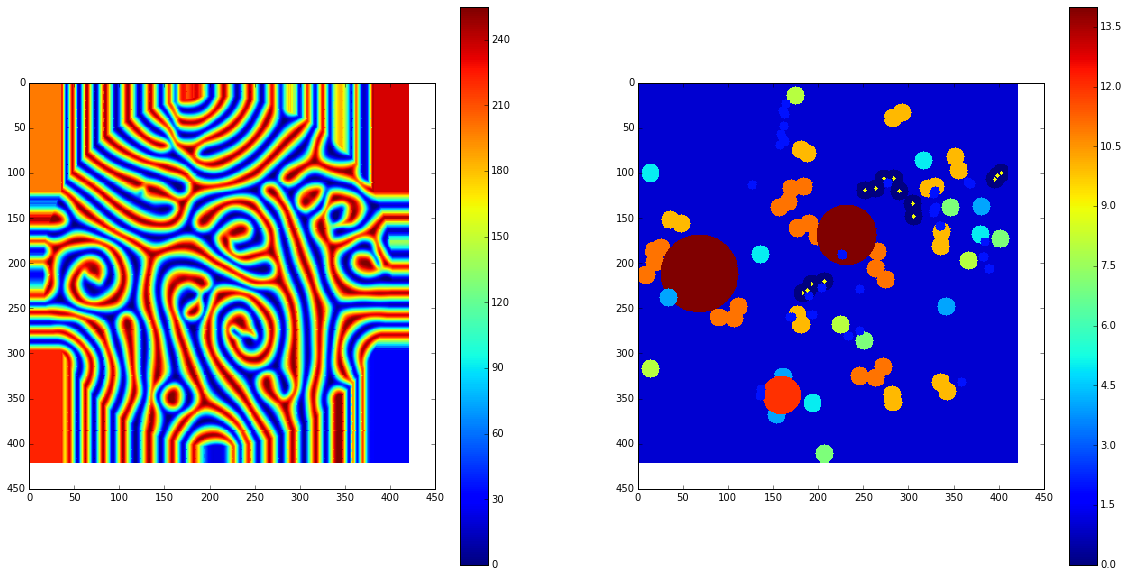

In [11]:
print maskids
Plot([bmp, mask])

In [12]:
image_defects

[[10, 1, 'center=(36,288)'],
 [10, 1, 'center=(76,184)'],
 [10, 1, 'center=(89,354)'],
 [5, 1, 'center=(86,317)'],
 [5, 1, 'center=(100,14)'],
 [11, 1, 'chain_length=1'],
 [4, 1, 'center=(137,381)'],
 [7, 1, 'center=(138,347)'],
 [10, 1, 'center=(154,42)'],
 [11, 1, 'chain_length=1'],
 [7, 1, 'center=(173,402)'],
 [11, 1, 'chain_length=1'],
 [11, 1, 'chain_length=1'],
 [5, 1, 'center=(190,136)'],
 [8, 1, 'center=(197,367)'],
 [14, 1, 'center=(212,69), radius=43.30'],
 [4, 1, 'center=(238,34)'],
 [11, 1, 'chain_length=1'],
 [4, 1, 'center=(248,342)'],
 [8, 1, 'center=(268,225)'],
 [11, 1, 'chain_length=1'],
 [8, 1, 'center=(317,14)'],
 [4, 1, 'center=(326,161)'],
 [4, 1, 'center=(368,154)'],
 [12, 1, 'center=(347,160), radius=21.36'],
 [10, 1, 'center=(337,339)'],
 [10, 1, 'center=(350,282)'],
 [5, 1, 'center=(355,194)'],
 [7, 1, 'center=(411,207)'],
 [8, 0, 'center=(14,175)'],
 [10, 0, 'center=(116,326)'],
 [14, 0, 'center=(169,232), radius=33.51'],
 [10, 0, 'center=(173,336)'],
 [5, 0

In [43]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(singular_points[['x','y']], 'single')

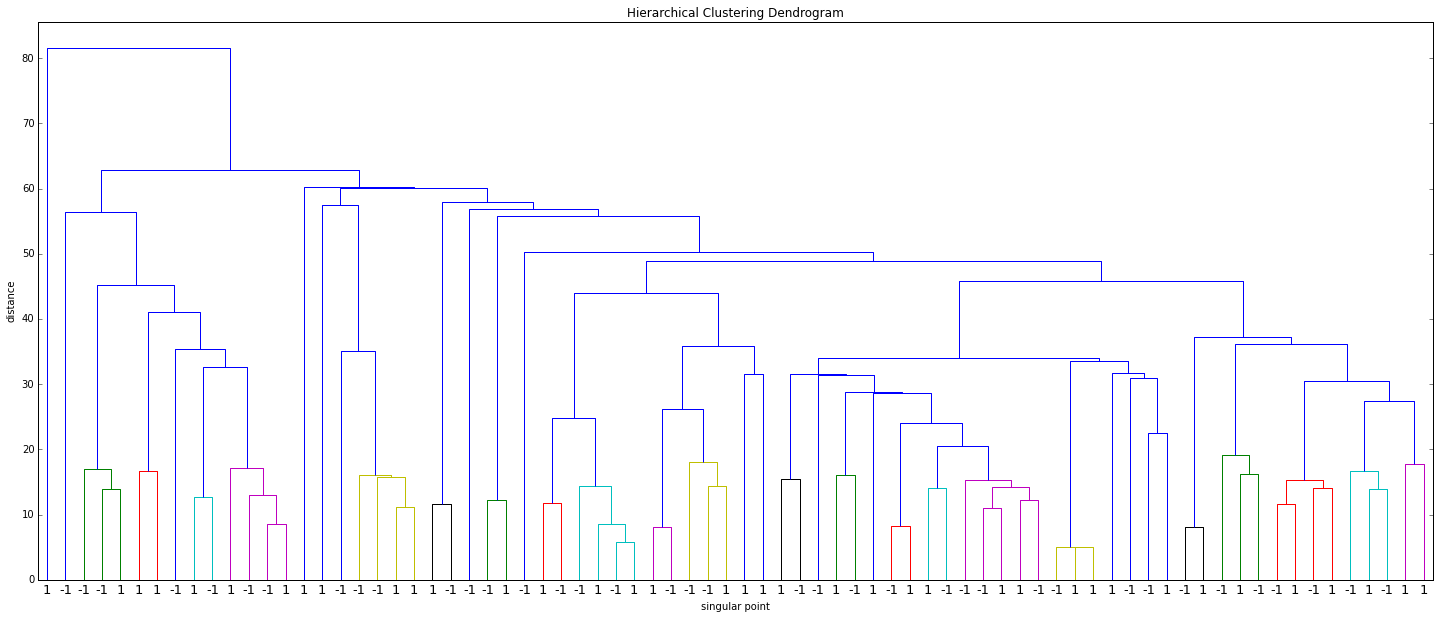

In [45]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('singular point')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=360.,
    leaf_font_size=13.,  # font size for the x axis labels
    color_threshold=20, # One wavelength
    labels=np.asarray(singular_points['type']),
)
plt.show()